In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import KNNImputer

from geopy.distance import geodesic

import plotly.express as px

import holidays

import scipy.stats as stats


In [2]:
# Carga el dataset en un dataframe
df = pd.read_csv('uber_fares.csv')

# Revisa si hay filas duplicadas
df.duplicated().sum() # 0 filas duplicadas

# Revisa las columnas y sus tipos de datos
df.dtypes


key                    int64
date                  object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [3]:
# Asigna el tipo de datos correcto a las variables que representan fechas
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime']).dt.floor('s')
df['date'] = pd.to_datetime(df['date']).dt.floor('s')

# Muestra las primeras filas del dataframe
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5


# Limpieza y preprocesamiento

In [4]:
# Elimina la columna 'key' que no aporta información relevante
df = df.drop(columns=['key'])

# Chequea si las columnas 'pickup_datetime' y 'date' son iguales
df['pickup_datetime'].equals(df['date']) # True

# Elimina la columna 'pickup_datetime' ya que es redundante
df = df.drop(columns=['pickup_datetime'])

In [5]:
# Elimina las filas cuya variable objetivo no es un valor posible
df = df[df['fare_amount'] > 0] # 0.01% de los datos

#### Null Island
Isla ficticia, ubicada en 0°N 0°E, que los GPS suelen utilizar como ubicación por defecto cuando fallan y no pueden determinar la ubicación real, es decir, representa una ubicación nula.

In [6]:
df_sin_null_island = df[
    ~(
        (df['pickup_latitude'] == 0) & (df['pickup_longitude'] == 0) |
        (df['dropoff_latitude'] == 0) & (df['dropoff_longitude'] == 0)
    )
]

print(f"Los viajes que comenzaron o terminaron en Null Island representan el {100 * (1 - df_sin_null_island.shape[0] / df.shape[0]):.2f}% de los datos.")

Los viajes que comenzaron o terminaron en Null Island representan el 1.97% de los datos.


In [7]:
# Elimina las filas que corresponden a viajes que empezaron o terminaron en Null Island
df = df_sin_null_island

In [8]:
# Genera un nuevo dataframe con todas las coordenadas
coordenadas = pd.concat(
    [
        df[['pickup_latitude', 'pickup_longitude']].rename(
            columns={'pickup_latitude': 'latitude', 'pickup_longitude': 'longitude'}
        ).assign(type='pickup'),
        df[['dropoff_latitude', 'dropoff_longitude']].rename(
            columns={'dropoff_latitude': 'latitude', 'dropoff_longitude': 'longitude'}
        ).assign(type='dropoff')
    ], ignore_index=True
)

# Muestra un mapa de las ubicaciones de inicio y fin del viaje
fig = px.scatter_map(
    coordenadas.sample(50000),
    lat="latitude",
    lon="longitude",
    color="type",
    zoom=5,
    title="Ubicaciones"
)

fig.update_layout(
    mapbox_style="open-street-map",
    margin={"r":0,"t":30,"l":0,"b":0}  # elimina márgenes blancos
)
fig.show()


A simple vista se observa que hay una gran densidad de viajes en Nueva York

In [9]:
limites_ny = {
    'lat_min': 40.49,
    'lat_max': 40.92,
    'lon_min': -74.27,
    'lon_max': -73.68
}

cantidad_viajes = df.shape[0]

# Filtra los viajes que se dieron de los límites de Nueva York
df_ny = df[
    (df['pickup_latitude'] >= limites_ny['lat_min']) &
    (df['pickup_latitude'] <= limites_ny['lat_max']) &
    (df['pickup_longitude'] >= limites_ny['lon_min']) &
    (df['pickup_longitude'] <= limites_ny['lon_max']) &
    (df['dropoff_latitude'] >= limites_ny['lat_min']) &
    (df['dropoff_latitude'] <= limites_ny['lat_max']) &
    (df['dropoff_longitude'] >= limites_ny['lon_min']) &
    (df['dropoff_longitude'] <= limites_ny['lon_max'])
]
cantidad_viajes_ny = df_ny.shape[0]

print(f"Los viajes dentro de los límites de Nueva York representan el {cantidad_viajes_ny / cantidad_viajes * 100:.2f}% del total.")


Los viajes dentro de los límites de Nueva York representan el 99.74% del total.


TODO Vamos a reducir el alcance de nuestro modelo predictivo a viajes integramente dentro de la ciudad de Nueva York, ya que etc COMPLETAR

In [10]:
# Elimina las filas que corresponden a viajes que no se dieron dentro de los límites de Nueva York
df = df_ny

Los valores posibles para la variable passenger_count están en el rango [0;6]. (UberX permite hasta 4 y UberXL hasta 6).

In [11]:
# Análisis de viajes con cantidad de pasajeros no válida
df[(df['passenger_count'] > 6)]

,date,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
113038,2010-12-28 08:20:00,11.7,-73.937795,40.758498,-73.937835,40.758415,208


In [12]:
# Elimina la fila con passenger_count = 208, que es la única con valor absurdo.
df = df[df['passenger_count'] <= 6]

In [13]:
print(f"Hasta acá dropeamos un {100 - df.shape[0] / 200000 * 100:.2f}% de los datos.")

Hasta acá dropeamos un 2.24% de los datos.


## Generación de nuevas variables

In [14]:
def imputar_distancia(viaje):
    '''
    Calcula la distancía  en kilometros del viaje
    mediante una combinación de distancia Manhattan con
    distancia geodésica (teniendo en cuenta la curvatura
    de la Tierra.)
    '''
    lat1 = viaje['pickup_latitude']
    lon1 = viaje['pickup_longitude']
    lat2 = viaje['dropoff_latitude']
    lon2 = viaje['dropoff_longitude']

    distancia_lat = np.float32(geodesic((lat1, lon1), (lat2, lon1)).kilometers)
    distancia_lon = np.float32(geodesic((lat2, lon1), (lat2, lon2)).kilometers)

    return distancia_lat + distancia_lon

df['distance'] = df.apply(imputar_distancia, axis=1)

In [15]:
df["hour_sin"] = np.sin(2 * np.pi * df['date'].dt.hour / 24)
df["hour_cos"] = np.cos(2 * np.pi * df['date'].dt.hour / 24)

df["weekday_sin"] = np.sin(2 * np.pi * df['date'].dt.day_of_week / 7)
df["weekday_cos"] = np.cos(2 * np.pi * df['date'].dt.day_of_week / 7)

df["month_sin"] = np.sin(2 * np.pi * df['date'].dt.month / 12)
df["month_cos"] = np.cos(2 * np.pi * df['date'].dt.month / 12)

In [16]:
us_holidays = holidays.US(years=df["date"].dt.year.unique(), state="NY")
df["holiday"] = df["date"].dt.date.isin(us_holidays)

In [17]:
df[df['holiday'] == True]

,date,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,hour_sin,hour_cos,weekday_sin,weekday_cos,month_sin,month_cos,holiday
5,2011-02-12 02:27:09,4.9,-73.969019,40.755910,-73.969019,40.755910,1,0.000000,0.500000,8.660254e-01,-0.974928,-0.222521,8.660254e-01,0.500000,True
22,2009-11-26 02:58:00,4.1,-74.010798,40.726085,-74.009767,40.737402,2,1.343825,0.500000,8.660254e-01,0.433884,-0.900969,-5.000000e-01,0.866025,True
25,2009-02-12 17:52:18,9.5,-73.986059,40.757159,-73.976130,40.780589,1,3.440031,-0.965926,-2.588190e-01,0.433884,-0.900969,8.660254e-01,0.500000,True
68,2015-02-16 11:19:55,8.5,-73.997650,40.736221,-73.981812,40.761349,2,4.127756,0.258819,-9.659258e-01,0.000000,1.000000,8.660254e-01,0.500000,True
89,2013-02-15 18:49:00,6.5,-73.992605,40.733957,-73.980698,40.742135,1,1.913849,-1.000000,-1.836970e-16,-0.433884,-0.900969,8.660254e-01,0.500000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199894,2011-11-11 17:09:00,6.5,-73.999908,40.718160,-74.008627,40.718038,3,0.750240,-0.965926,-2.588190e-01,-0.433884,-0.900969,-5.000000e-01,0.866025,True
199896,2009-12-25 09:49:00,8.1,-73.986803,40.733858,-73.966897,40.767220,5,5.385493,0.707107,-7.071068e-01,-0.433884,-0.900969,-2.449294e-16,1.000000,True
199911,2013-10-14 10:33:05,7.5,-73.990171,40.737398,-73.985515,40.746959,1,1.454967,0.500000,-8.660254e-01,0.000000,1.000000,-8.660254e-01,0.500000,True
199922,2010-10-11 17:36:45,6.5,-73.998830,40.744831,-73.997079,40.761215,1,1.967280,-0.965926,-2.588190e-01,0.000000,1.000000,-8.660254e-01,0.500000,True


In [18]:
# Separa el 80% para train y 20% para test
train, test= train_test_split(df, test_size=0.2, random_state=1)

# EDA

<Axes: xlabel='fare_amount', ylabel='Density'>

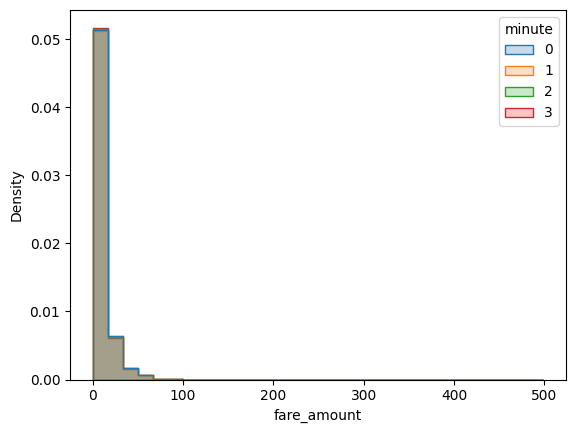

In [19]:
# dummys de minutos (0-14, 15-29, 30-44, 45-59)
train['minute'] = train['date'].dt.minute
train['minute'] = pd.cut(train['minute'], bins=[-1, 14, 29, 44, 59], labels=[0, 1, 2, 3])

# grafico de precio por minuto
# sns.scatterplot(x='minute', y='fare_amount', data=train)

# histogramas de precio para cada rango de minutos
sns.histplot(data=train, x='fare_amount', hue='minute', element='step', stat='density', common_norm=False, bins=30)

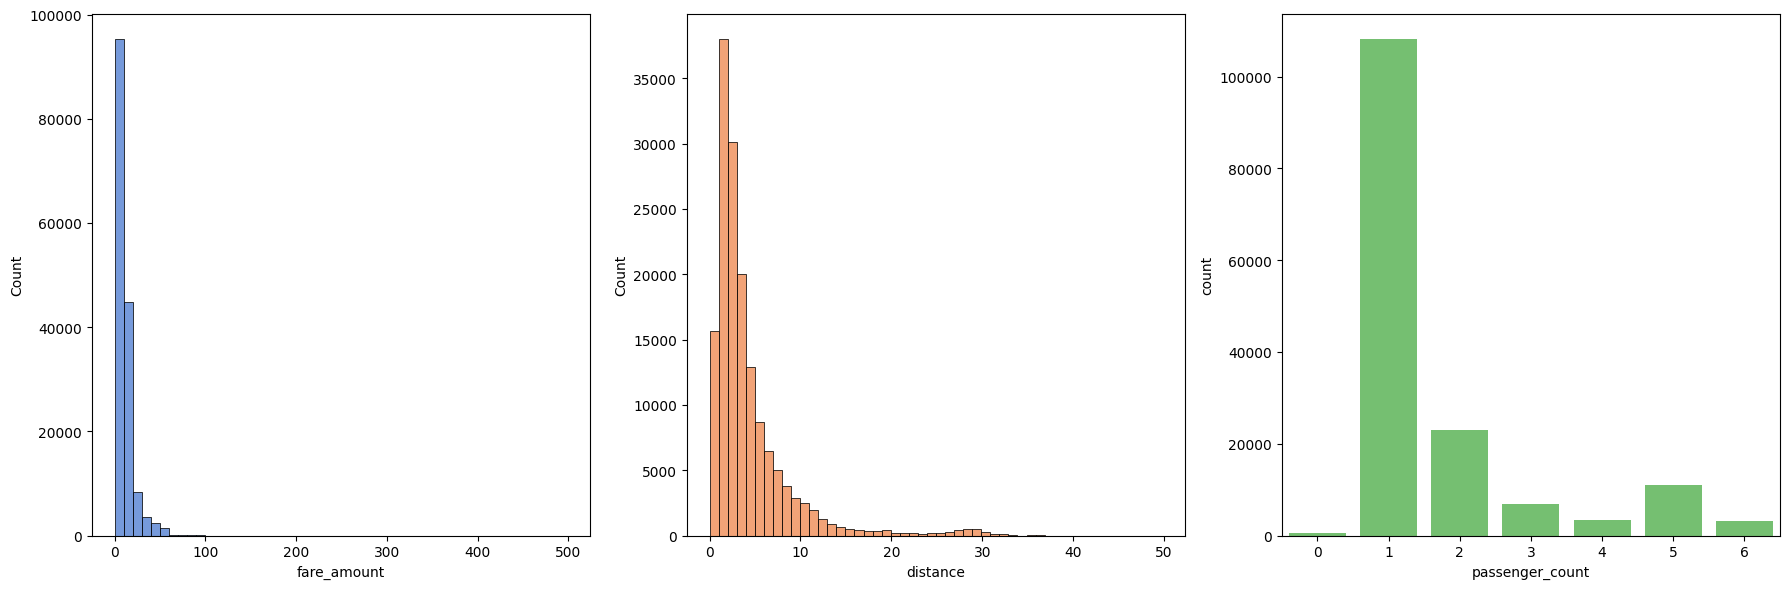

In [20]:
# Distribución de variables

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 fila, 2 columnas

sns.histplot(data=train, x='fare_amount', bins=50, color=sns.color_palette("muted")[0], ax=axes[0])

sns.histplot(data=train, x='distance', bins=50, color=sns.color_palette("muted")[1], ax=axes[1])

sns.countplot(data=train, x='passenger_count', color=sns.color_palette("muted")[2], ax=axes[2])

plt.tight_layout()
plt.show()

Se observa que tanto 'fare_amount' como 'distance' están sesgadas hacía la derecha.

<Axes: xlabel='distance', ylabel='fare_amount'>

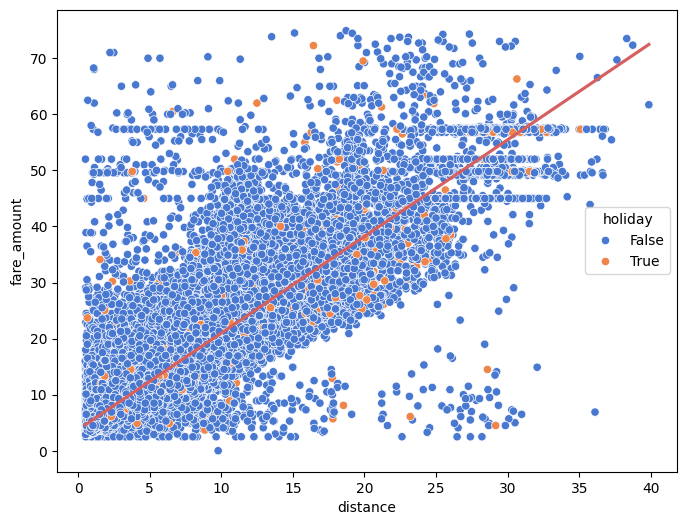

In [21]:
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(data=train[(train['distance'] > .5) & (train['fare_amount'] < 75)], x='distance', y='fare_amount', hue='holiday', palette='muted')
sns.regplot(data=train[(train['distance'] > .5) & (train['fare_amount'] < 75)], x='distance', y='fare_amount', scatter=False, color=sns.color_palette("muted")[3], line_kws={'linestyle': 'solid'}, ax=ax)

In [22]:
train['fare_amount'].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99, 0.999])

count    156420.000000
mean         11.284068
std           9.503064
min           0.010000
1%            3.300000
5%            4.100000
25%           6.000000
50%           8.500000
75%          12.500000
95%          30.000000
99%          52.000000
99.9%        75.000000
max         499.000000
Name: fare_amount, dtype: float64

In [23]:
# Análisis de valores de 'fare_amount' mayores al 99.9% de los datos
train[train['fare_amount'] > train['fare_amount'].quantile(0.999)][['fare_amount', 'distance', 'passenger_count']]

,fare_amount,distance,passenger_count
114335,89.65,27.751038,1
179738,86.90,22.933472,1
120449,89.00,0.000000,1
142975,80.55,24.440781,1
117697,81.25,21.431232,2
...,...,...,...
104168,85.16,0.057804,1
104375,92.50,24.361694,2
42143,99.00,15.015394,1
189426,84.00,19.844074,1


In [24]:
train['distance'].describe()

count    156420.000000
mean          4.262475
std           4.698390
min           0.000000
25%           1.602829
50%           2.770420
75%           5.036725
max          49.804722
Name: distance, dtype: float64

Como la distancia del viaje no puede ser 0 (porque si no no habría viaje), reemplazamos los valores 0 de 'distance' por nulos, para tratarlos luego.

In [25]:
train = train.assign(distance=lambda x: x['distance'].replace(0, np.nan))
test = test.assign(distance=lambda x: x['distance'].replace(0, np.nan))

train['distance'].describe(percentiles=[0.001, 0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

count    154850.000000
mean          4.305691
std           4.702405
min           0.000084
0.1%          0.001935
1%            0.283168
5%            0.777522
25%           1.631325
50%           2.798514
75%           5.078414
95%          12.365005
99%          28.009501
max          49.804722
Name: distance, dtype: float64

In [26]:
# Análisis de valores de 'fare_amount' mayores al 99.9% de los datos
train[(train['distance'] < .5) & (train['fare_amount'] > 75)][['fare_amount', 'distance', 'passenger_count']]

,fare_amount,distance,passenger_count
121825,94.00,0.004330,1
126977,75.54,0.002783,1
2053,113.66,0.175887,1
84854,92.00,0.001226,2
144171,107.50,0.001232,1
155062,120.00,0.001453,1
189013,76.00,0.177407,1
89591,85.00,0.284087,1
170081,499.00,0.000982,1
150980,110.00,0.340008,1


In [27]:
train[(train['distance'] < .5)]

,date,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,hour_sin,hour_cos,weekday_sin,weekday_cos,month_sin,month_cos,holiday,minute
2487,2009-12-09 15:30:39,2.5,-73.810164,40.691844,-73.810166,40.691835,1,0.001168,-0.707107,-7.071068e-01,0.974928,-0.222521,-2.449294e-16,1.000000e+00,False,2
56293,2014-02-21 14:32:02,3.0,-73.954073,40.778994,-73.950530,40.777303,1,0.486877,-0.500000,-8.660254e-01,-0.433884,-0.900969,8.660254e-01,5.000000e-01,False,2
138869,2009-10-19 10:31:00,6.5,-73.938305,40.758600,-73.937945,40.758445,1,0.047612,0.500000,-8.660254e-01,0.000000,1.000000,-8.660254e-01,5.000000e-01,False,2
140865,2013-03-18 18:18:57,6.0,-73.971365,40.760299,-73.968288,40.761709,2,0.416394,-1.000000,-1.836970e-16,0.000000,1.000000,1.000000e+00,6.123234e-17,False,1
6565,2010-12-13 11:12:00,3.3,-73.977560,40.789047,-73.977277,40.785618,1,0.404677,0.258819,-9.659258e-01,0.000000,1.000000,-2.449294e-16,1.000000e+00,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199156,2011-09-30 00:23:00,9.3,-73.999255,40.757613,-73.998677,40.756238,1,0.201502,0.000000,1.000000e+00,-0.433884,-0.900969,-1.000000e+00,-1.836970e-16,False,1
49241,2014-07-22 14:10:00,5.0,-73.971937,40.750392,-73.975290,40.748670,1,0.474401,-0.500000,-8.660254e-01,0.781831,0.623490,-5.000000e-01,-8.660254e-01,False,0
55822,2011-07-17 13:57:00,4.9,-74.099235,40.917048,-74.096575,40.914887,3,0.464071,-0.258819,-9.659258e-01,-0.781831,0.623490,-5.000000e-01,-8.660254e-01,False,3
81912,2014-09-05 18:25:00,3.5,-73.980992,40.784607,-73.980422,40.781582,1,0.384040,-1.000000,-1.836970e-16,-0.433884,-0.900969,-1.000000e+00,-1.836970e-16,False,1


<Axes: xlabel='fare_amount', ylabel='Count'>

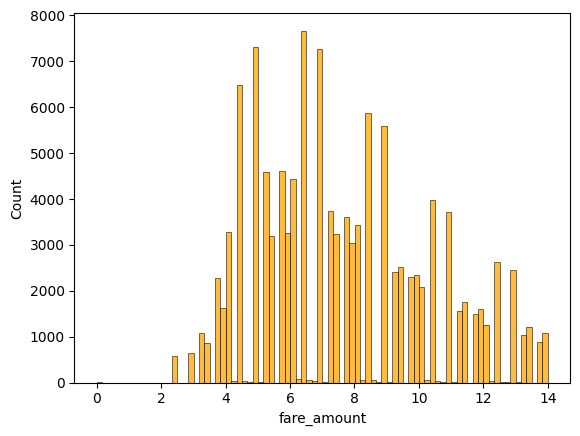

In [28]:
sns.histplot(x=train[train['fare_amount'] < train['fare_amount'].quantile(0.80)]['fare_amount'], color='orange')


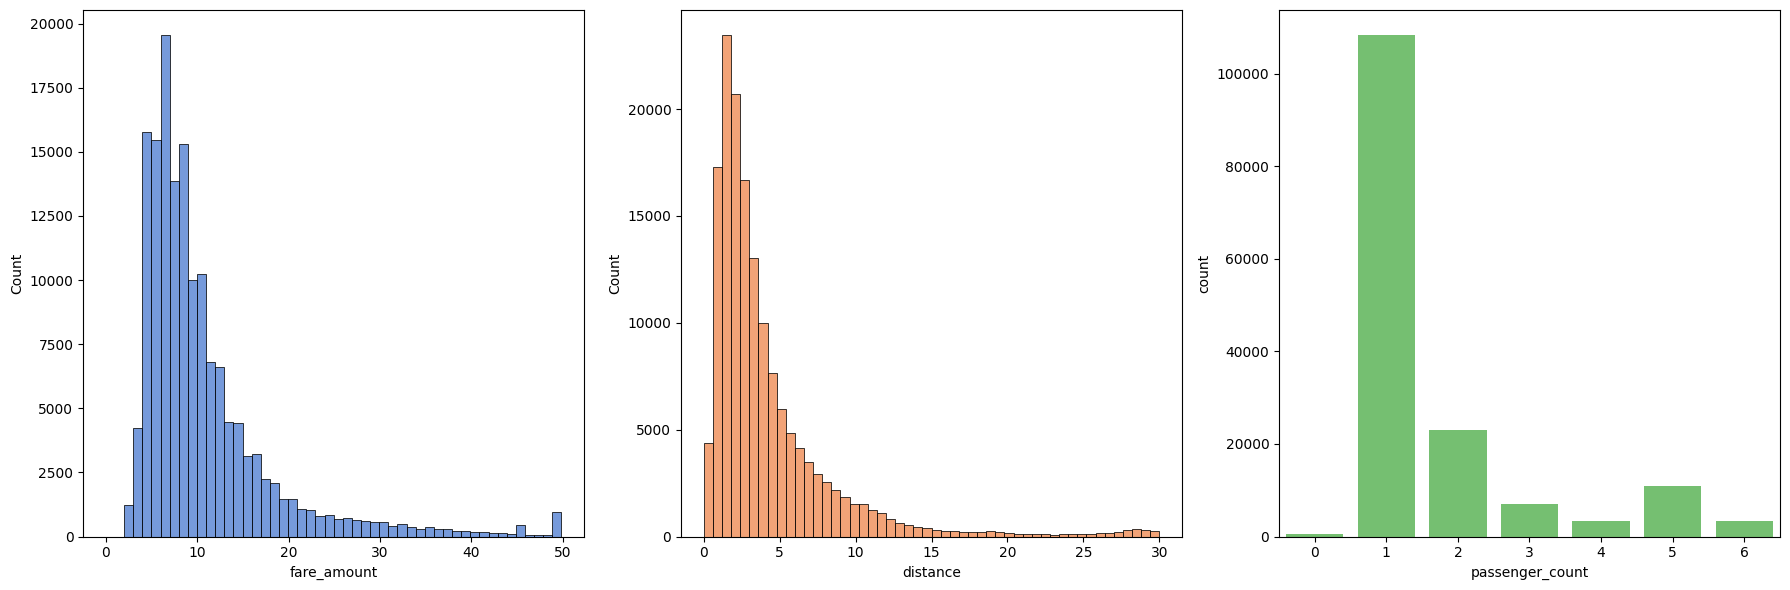

In [29]:
# Análisis de valores de 'fare_amount' mayores al 99.99% de los datos y distance < 0.5
train[(train['distance'] < 0.5) & (train['fare_amount'] > 100)][['fare_amount', 'distance', 'passenger_count']]
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 fila, 2 columnas

sns.histplot(data=train[train['fare_amount'] < 50], x='fare_amount', bins=50, color=sns.color_palette("muted")[0], ax=axes[0])

sns.histplot(data=train[train['distance'] < 30], x='distance', bins=50, color=sns.color_palette("muted")[1], ax=axes[1])

sns.countplot(data=train, x='passenger_count', color=sns.color_palette("muted")[2], ax=axes[2])

plt.tight_layout()
plt.show()

In [30]:
train[['fare_amount','distance','passenger_count']].describe(percentiles=[.01, .05, .1, .25, .5, .75, .9, .95, .999])

,fare_amount,distance,passenger_count
count,156420.000000,154850.000000,156420.000000
mean,11.284068,4.305691,1.681690
std,9.503064,4.702405,1.303887
min,0.010000,0.000084,0.000000
1%,3.300000,0.283168,1.000000
5%,4.100000,0.777522,1.000000
10%,4.500000,1.033535,1.000000
25%,6.000000,1.631325,1.000000
50%,8.500000,2.798514,1.000000
75%,12.500000,5.078414,2.000000


In [32]:
train

,date,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,hour_sin,hour_cos,weekday_sin,weekday_cos,month_sin,month_cos,holiday,minute
163706,2010-06-04 02:57:51,8.1,-73.987980,40.718646,-74.000804,40.736567,1,3.073337,0.500000,8.660254e-01,-0.433884,-0.900969,1.224647e-16,-1.000000,False,3
8806,2009-10-23 19:05:32,3.7,-73.960160,40.769962,-73.961102,40.776002,2,0.750262,-0.965926,2.588190e-01,-0.433884,-0.900969,-8.660254e-01,0.500000,False,0
32090,2013-12-18 10:25:00,5.5,-73.970432,40.788705,-73.980473,40.775062,1,2.362718,0.500000,-8.660254e-01,0.974928,-0.222521,-2.449294e-16,1.000000,False,1
179562,2009-11-25 15:53:00,7.3,-73.981562,40.780557,-73.985097,40.758393,5,2.759801,-0.707107,-7.071068e-01,0.974928,-0.222521,-5.000000e-01,0.866025,False,3
145548,2012-08-10 14:06:00,4.5,-73.969847,40.794832,-73.962600,40.804652,3,1.702036,-0.500000,-8.660254e-01,-0.433884,-0.900969,-8.660254e-01,-0.500000,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75002,2010-04-02 18:44:00,4.5,-73.969870,40.797372,-73.965162,40.791902,1,1.004795,-1.000000,-1.836970e-16,-0.433884,-0.900969,8.660254e-01,-0.500000,False,2
111798,2011-10-06 06:52:00,4.5,-73.991237,40.755685,-73.982998,40.758808,1,1.042517,1.000000,6.123234e-17,0.433884,-0.900969,-8.660254e-01,0.500000,False,3
51188,2012-06-16 23:26:51,10.5,-73.970522,40.796626,-73.940021,40.825456,1,5.774544,-0.258819,9.659258e-01,-0.974928,-0.222521,1.224647e-16,-1.000000,False,1
5297,2009-10-21 17:36:00,11.3,-73.983088,40.767890,-74.000903,40.735132,1,5.142599,-0.965926,-2.588190e-01,0.974928,-0.222521,-8.660254e-01,0.500000,False,2


<Axes: xlabel='fare_amount', ylabel='Count'>

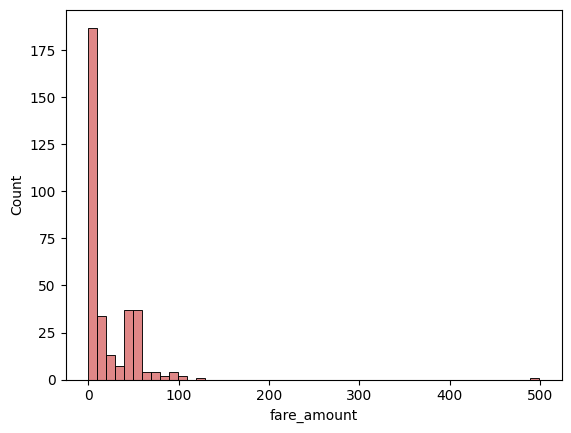

In [ ]:
sns.histplot(data=train[train['distance'] == 0], x='fare_amount', bins=50, color=sns.color_palette("muted")[3])